
# Compute image contrast

This notebook contains (and downloads) all the required code to compute stimulus contrast.

It uses two methods, the method from Groen et al. (2013), this one has some advantages because it automatically selects the relevant scale, and should work well (better?) with RGB images. And more traditional methods implemented by me (Micha). The first is implemented by Niklas in Python.

We go over each in turn.

In [1]:
import sys

# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install gdown
# !{sys.executable} -m pip install 



In [3]:
#@title first we import some packages and download the stimuli (run cell)
import gdown
import zipfile
import os,sys
import numpy as np

# Function to download and extract zip files from Google Drive, then remove the zip file
def download_and_extract_from_drive(files):
    for zip_fname, url in files.items():
        # Extract the file ID from the provided URL for gdown
        url_id = url.split('/d/')[1].split('/')[0] if '/d/' in url else url.split('/')[-2]
        gdown_url = f'https://drive.google.com/uc?id={url_id}'

        # Download the file
        try:
          gdown.download(gdown_url, zip_fname, quiet=False)
        except:
          print(f'failed to download: {gdown_url}')

        # Unzip the file in the current directory
        with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
            zip_ref.extractall('.')

        # Remove the ZIP file after extracting its contents
        os.remove(zip_fname)

# Dictionary of zip filenames and their Google Drive links
files_to_download = {
    'selected_imgs.zip': 'https://drive.google.com/file/d/1p9YO-81sQzweR_Sha0qd-upA-qKKfkCI/',
    'gabor.zip': 'https://drive.google.com/file/d/16KJyzTbYVsF8GF3rbE_1Lxk3hhvzDNIs'
}

# Download and extract the files
download_and_extract_from_drive(files_to_download)
!git clone https://github.com/niklas-mueller/lgnpy.git
!pip install -e ./lgnpy
!{sys.executable} -m pip install mat73


Downloading...
From (original): https://drive.google.com/uc?id=1p9YO-81sQzweR_Sha0qd-upA-qKKfkCI
From (redirected): https://drive.google.com/uc?id=1p9YO-81sQzweR_Sha0qd-upA-qKKfkCI&confirm=t&uuid=1aac166f-b9c1-4e66-a2b4-94359bead113
To: /home/rfpred/notebooks/alien_nbs/selected_imgs.zip
100%|██████████| 85.9M/85.9M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=16KJyzTbYVsF8GF3rbE_1Lxk3hhvzDNIs
To: /home/rfpred/notebooks/alien_nbs/gabor.zip
100%|██████████| 14.7k/14.7k [00:00<00:00, 15.9MB/s]


fatal: destination path 'lgnpy' already exists and is not an empty directory.
Obtaining file:///home/rfpred/notebooks/alien_nbs/lgnpy
  Preparing metadata (setup.py) ... done
  Attempting uninstall: lgnpy
    Found existing installation: lgnpy 1.0
    Uninstalling lgnpy-1.0:
      Successfully uninstalled lgnpy-1.0
  Running setup.py develop for lgnpy


## Manual code change required!
For the Groen/Ghrebab method, we use Niklas' code, which has a bug!
You need to adjust this line in the file:
`/lgnpy/lgnpy/CEandSC/lgn_statistics.py`
```python
    lgn = LGN(config=config, default_config_path=f'{home_path}/projects/lgnpy/lgnpy/CEandSC/default_config.yml')
```
into:
```python
    lgn = LGN(config=config, default_config_path=f'{home_path}/lgnpy/lgnpy/CEandSC/default_config.yml')
```

If you want to use the Groen method, you need to do this manually -- or do a pull request and fix the thing on github -- or change the  code locally and upload new one to google drive, or...|

In [2]:
#@title  other info relating to distance and degree per pixel (run hidden cell)
import sys
import os
import numpy as np
from contextlib import contextmanager

@contextmanager
def suppress_print():
    """
    Context manager to suppress printing to the console.
    """
    original_stdout = sys.stdout  # Save the original stdout
    sys.stdout = open(os.devnull, 'w')  # Redirect stdout to a null device

    try:
        yield
    finally:
        sys.stdout.close()  # Close the null device
        sys.stdout = original_stdout  # Restore the original stdout

# define screen-specific information

def pix2hoek(pix, disp_dim, disp_dim_pix, disp_dist):
    """
    Converts a distance in pixels on the screen into visual angle for an observer
    viewing from distance disp_dist.

    Parameters:
    - pix (float): object size in pixels.
    - disp_dim (float): height or width of screen, in same units as disp_dist.
    - disp_dim_pix (float): height or width of screen, in pixels.
    - disp_dist (float): distance of screen from the observer.

    Returns:
    float: object size in visual angles (degrees).
    """

    cpp = disp_dim / disp_dim_pix  # cpp = centimeter per pixel
    alpha = (0.5 * (pix * cpp)) / disp_dist  # alpha is half the angle
    hoek = 2 * np.degrees(np.arctan(alpha))  # hoek is object size in degrees

    return hoek

# deg_per_pixel=pix2hoek(1.5, 0.6773, 2560, .46) # this is incorrect?
# # deg_per_pixel=.04
# print('degree per pixel:', deg_per_pixel)

# For NSD:
deg_per_pixel = 8.4 / 425
print('degree per pixel:', deg_per_pixel)

degree per pixel: 0.01976470588235294


# Compute contrast a la Groen et al.

In the cells below, contrast is computed with the method of Groen et al.

This is nice because it does automatic relevant scale selection (so you don't have separate contrast estimates for different spatial frequencies). Moreover, it works nicely with colour (RGB) images.

One thing to pay attention to, is how the distance and "dot pitch" are defined

mask dims: (256, 256)
<class 'PIL.PngImagePlugin.PngImageFile'>


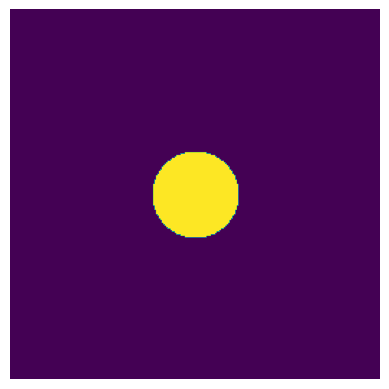

In [3]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_files=glob.glob('selected_imgs/img*.jpg')
mask=Image.open('selected_imgs/mask.png')
plt.imshow(mask)
plt.axis('off')
print(f'mask dims: {mask.size}')
print(type(mask))
image_files.sort()

### After having changed the line in the lgn_statistics.py file, you will encounter an error in the following code block as well. To fix this, do the following: In the code below, you have to change all the double lgnpy. statements into single ones.

(already done in this case)


So instead of lgnpy.lgnpy.CEandSC.lgn_statistics --> lgnpy.CEandSC.lgn_statistics

In [4]:
import imp
import yaml

import cv2
import lgnpy.CEandSC.lgn_statistics
imp.reload(lgnpy.CEandSC.lgn_statistics)
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat

# compute dotpix
img_ix=1
meter_per_pixel=0.6773/2560
dot_pitch=(3 * meter_per_pixel / 2)*1.5 # dot pitch in meter (times 1.5 because we upscale the image)

config_path = 'lgnpy/lgnpy/CEandSC/default_config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.UnsafeLoader)
config['viewing_dist']=0.46
config['dot_pitch']= dot_pitch

/tmp/ipykernel_3676735/1049579510.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [5]:
import time
import pandas as pd
# threshold_lgn = loadmat(filepath='/content/lgnpy/ThresholdLGN.mat')['ThresholdLGN']
threshold_lgn = loadmat(filepath='./lgnpy/ThresholdLGN.mat')['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [6]:
from scipy.ndimage import binary_dilation

# Function to create a circle mask
def make_circle_mask(size, center_row, center_col, radius, fill='y', margin_width=1):
    rows = np.arange(size)
    cols = np.arange(size)
    rows, cols = np.meshgrid(rows, cols)

    # Calculate the distance from each point to the center
    distances = np.sqrt((rows - center_row)**2 + (cols - center_col)**2)

    # Create a binary mask where values within the radius are set to 1, others to 0
    circle_mask = np.where(distances <= radius, 1, 0)

    # Create a dilated version of the binary mask to add a margin
    dilated_circle_mask = binary_dilation(circle_mask, iterations=margin_width)

    # Subtract the dilated version to create the outline
    outline_circle_mask = circle_mask - dilated_circle_mask

    if fill == 'y':
        return circle_mask
    elif fill == 'n':
        return -outline_circle_mask

<class 'numpy.bool_'>
<class 'tuple'>


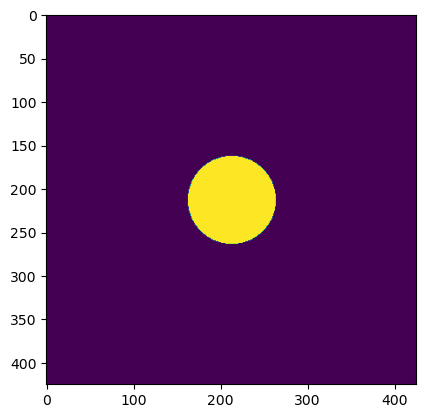

In [7]:
# from funcs.rf_tools import css_gaussian_cut, make_circle_mask
# w_mask = css_gaussian_cut(425, 213, 213, (425/8.4))
w_mask = np.array(make_circle_mask(425, 213, 213, (425/8.4)), dtype=bool)
plt.imshow(w_mask)
mask_list = [w_mask] * 5

print(type(w_mask[0][0]))

print(type(w_mask.shape))

In [8]:
# Function to show a randomly selected image of the nsd dataset
def show_stim(hide = 'n', img_no = 'random', small = 'n'):
    # Example code to show how to access the image files, these are all 73000 of them, as np.arrays
    # I keep it like this as it might be useful to also store the reconstructed images with the autoencoder
    # using a .hdf5 folder structure, but I can change this later on.

    stim_dir = '/home/rfpred/data/natural-scenes-dataset/nsddata_stimuli/stimuli/nsd/'
    stim_files = os.listdir(stim_dir)

    with h5py.File(f'{stim_dir}{stim_files[0]}', 'r') as file:
        img_brick_dataset = file['imgBrick']
        
        if img_no == 'random':
            image_no = random.randint(0,img_brick_dataset.shape[0])
        else: image_no = img_no
        
        test_image = img_brick_dataset[image_no]
    hor = ver = 10
    if small == 'y':
        hor = ver = 5        
    if hide == 'n':
        plt.figure(figsize=(hor, ver))
        plt.imshow(test_image)
        plt.title(f'Image number {image_no}')
        plt.axis('off')
        plt.show()
        
    return test_image, image_no

In [9]:
import h5py

In [10]:
tstart=time.time()
stim_dict={k:[] for k in ['img_ix','CE_summ','SC_summ']}

all_imgs = len(image_files)
n_imgs = 1

for img_ix in range(n_imgs):
    if img_ix%250==0:
        print(f'now doing img {img_ix}/{len(image_files)}')
        print('time elapsed so far: ',round(time.time()-tstart,2))
        
    if n_imgs == 1:
        img_ix = 5736
# im = cv2.imread(image_files[img_ix])
    with suppress_print():
        ce, sc, beta, gamma, edge_dict = lgn_statistics(im=show_stim(img_no = img_ix, hide = 'y')[0], file_name='noname.tiff',
                                             config=config, force_recompute=True, cache=False,
                                             home_path='./', verbose = True, 
                                             threshold_lgn=threshold_lgn, compute_extra_statistics=True)
    # fill the dict
    stim_dict['img_ix'].append(str(img_ix).zfill(4))
    stim_dict['CE_summ'].append(ce[0][0][0])
    stim_dict['SC_summ'].append(sc[0][0][0])

contr_df=pd.DataFrame(stim_dict)


now doing img 0/6901
time elapsed so far:  0.0


In [11]:
print(threshold_lgn)

[[2.98873239e-02 1.89810011e-03 1.41080865e-03]
 [6.13561269e-03 6.27423780e-04 2.96135435e-04]
 [1.59229199e-03 2.33047347e-04 8.64881055e-05]
 [4.63650433e-04 6.83552939e-05 2.37220015e-05]
 [1.31772218e-04 1.74326112e-05 6.31894821e-06]
 [3.64672775e-05 4.31775970e-06 1.26552652e-06]]


In [12]:
# from matplotlib import colormaps
# list(colormaps)

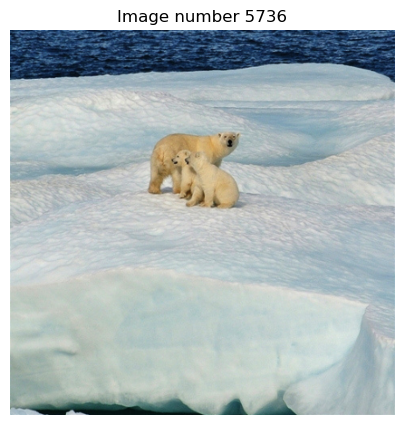

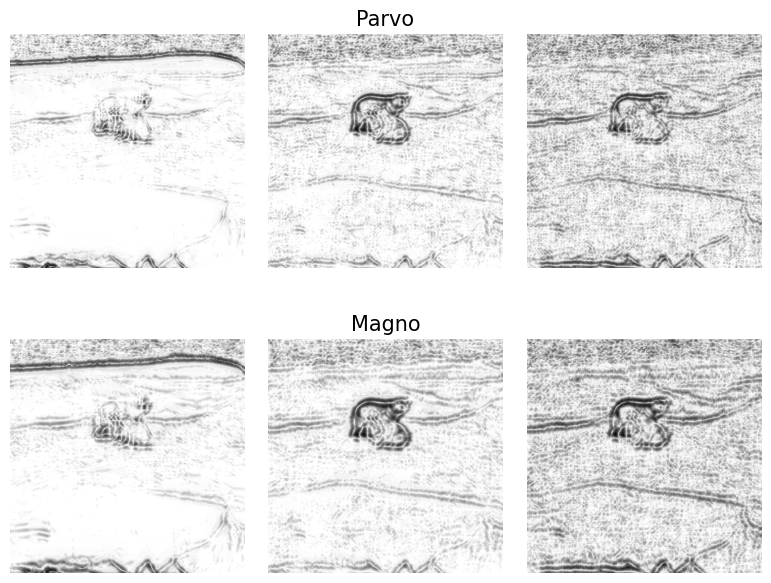

In [13]:
# contr_df

show_stim(img_no = img_ix, small = 'y')
cmap = 'binary'
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

axes[0, 0].imshow(edge_dict['par1'], cmap=cmap)
axes[0, 1].imshow(edge_dict['par2'], cmap=cmap)
axes[0, 1].set_title('Parvo', size = 15)
axes[0, 2].imshow(edge_dict['par3'], cmap=cmap)
axes[1, 0].imshow(edge_dict['mag1'], cmap=cmap)
axes[1, 1].imshow(edge_dict['mag2'], cmap=cmap)
axes[1, 1].set_title('Magno', size = 15)
axes[1, 2].imshow(edge_dict['mag3'], cmap=cmap)

for i in range(2):
    for j in range(3):
        axes[i, j].axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0.3)


In [14]:
def get_bounding_box(mask):
    # Get the indices where the mask is True
    y_indices, x_indices = np.where(mask)

    # Get the minimum and maximum indices along each axis
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    return x_min, x_max, y_min, y_max



# Create a circular mask
# mask = make_circle_mask(size, center_row, center_col, radius, fill='y')

# Get the bounding box of the mask
# x_min, x_max, y_min, y_max = get_bounding_box(mask)

# # Crop the array to the bounding box
# cropped_array = array[y_min:y_max+1, x_min:x_max+1]

In [15]:
# Function to create the Gaussian image
def make_gaussian_2d(size, center_row, center_col, sigma):
    rows = np.arange(size)
    cols = np.arange(size)
    rows, cols = np.meshgrid(rows, cols)
    exponent = -((rows - center_row)**2 / (2 * sigma**2) + (cols - center_col)**2 / (2 * sigma**2))
    gaussian = np.exp(exponent)
    return gaussian

# Function to create a circle mask
def make_circle_mask(size, center_row, center_col, radius, fill='y', margin_width=1):
    rows = np.arange(size)
    cols = np.arange(size)
    rows, cols = np.meshgrid(rows, cols)

    # Calculate the distance from each point to the center
    distances = np.sqrt((rows - center_row)**2 + (cols - center_col)**2)

    # Create a binary mask where values within the radius are set to 1, others to 0
    circle_mask = np.where(distances <= radius, 1, 0)

    # Create a dilated version of the binary mask to add a margin
    dilated_circle_mask = binary_dilation(circle_mask, iterations=margin_width)

    # Subtract the dilated version to create the outline
    outline_circle_mask = circle_mask - dilated_circle_mask

    if fill == 'y':
        return circle_mask
    elif fill == 'n':
        return -outline_circle_mask

def css_gaussian_cut(size, center_row, center_col, sigma):
    rows = np.arange(size)
    cols = np.arange(size)
    rows, cols = np.meshgrid(rows, cols)

    distances = np.sqrt((rows - center_row)**2 + (cols - center_col)**2)
    mask = np.where(distances <= sigma, 1, 0)

    exponent = -((rows - center_row)**2 / (2 * sigma**2) + (cols - center_col)**2 / (2 * sigma**2))
    gaussian = np.exp(exponent)
    gaussian *= mask
    return gaussian

# These two functions are coupled to run the feature computations in parallel.
# This saves a lot of time. Should be combined with the feature_df function to assign
# the values to the corresponding trials.
def rms_single(args, ecc_max = 1, loc = 'center', plot = 'n', normalise = True, crop_prior:bool = False, crop_post:bool = False, save_plot:bool = False, cmap = 'gist_gray'):
    i, start, n, plot, loc, crop_prior, crop_post, save_plot  = args
    dim = show_stim(hide = 'y')[0].shape[0]
    radius = ecc_max * (dim / 8.4)
    if loc == 'center':
        x = y = (dim + 1)/2
    elif loc == 'irrelevant_patch':
        x = y = radius + 10
        
    mask_w_in = css_gaussian_cut(dim, x, y, radius)
    rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    full_ar_in = ar_in = show_stim(img_no = i, hide = 'y')[0]  
    
    if i % 100 == 0:
        print(f"Processing image number: {i} out of {n + start}")
        
    if crop_prior:
        
        x_min, x_max, y_min, y_max = get_bounding_box(rf_mask_in)
        
        ar_in = ar_in[x_min:x_max, y_min:y_max]
        mask_w_in = mask_w_in[x_min:x_max, y_min:y_max]
        rf_mask_in = rf_mask_in[x_min:x_max, y_min:y_max]
        
    return get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, full_ar_in, normalise = normalise, 
                                plot = plot, cmap = cmap, crop_prior = crop_prior, crop_post = crop_post, 
                                save_plot = save_plot)

# Function that calculates rms but based on a RGB to LAB conversion, which follows the CIELAB colour space
# This aligns best with the way humans perceive visual input. 
def get_rms_contrast_lab(rgb_image, mask_w_in, rf_mask_in, full_array, normalise = True, plot = 'n', cmap = 'gist_gray', crop_prior:bool = False, crop_post:bool = False, save_plot:bool = False):
    # Convert RGB image to LAB colour space
    lab_image = color.rgb2lab(rgb_image)
    
    ar_in = lab_image[:, :, 0] # Extract the L* channel for luminance values, set as input array
        
    if normalise == True:
        ar_in = ar_in/np.max(ar_in)
    
    square_contrast=np.square((ar_in-(ar_in[rf_mask_in].mean())))
    msquare_contrast=(mask_w_in*square_contrast).sum()
    
    if crop_post:     
        x_min, x_max, y_min, y_max = get_bounding_box(rf_mask_in)
        
        square_contrast = square_contrast[x_min:x_max, y_min:y_max]
        mask_w_in = mask_w_in[x_min:x_max, y_min:y_max]
    
    if plot == 'y':
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        plt.subplots_adjust(wspace=0.01)

        axs[1].set_title(f'rms = {np.sqrt(msquare_contrast):.2f}')
        axs[0].imshow(square_contrast, cmap = cmap)
        axs[0].axis('off') 
        axs[1].imshow(mask_w_in*square_contrast, cmap = cmap)
        axs[1].axis('off') 
        
        if save_plot:
            plt.savefig(f'rms_crop_prior_{str(crop_prior)}_crop_post_{str(crop_post)}.png')
            
    return (np.sqrt(msquare_contrast))

def rms_all(start, n, ecc_max = 1, plot = 'n', loc = 'center', crop_prior:bool = False, crop_post:bool = True, save_plot:bool = False):
    img_vec = list(range(start, start + n))

    # Create a pool of worker processes
    with Pool() as p:
        rms_vec = p.map(rms_single, [(i, start, n, plot, loc, crop_prior, crop_post, save_plot) for i in img_vec])

    rms_dict = pd.DataFrame({
        'rms': rms_vec
    })

    rms_dict = rms_dict.set_index(np.array(img_vec))
    return rms_dict


In [16]:
from multiprocessing import Pool
import os
import h5py
import random
import numpy as np
from scipy.ndimage import binary_dilation
from skimage import color
import matplotlib.pyplot as plt
import pandas as pd
import random
from skimage import color

rms_crop_post = rms_all(121, 2, plot = 'y', loc = 'center', crop_prior = False, crop_post = True)
rms_crop_prior = rms_all(121, 2, plot = 'y', loc = 'center', crop_prior = True, crop_post = False)

print(f'rms with crop posterior to rms calculation: \n{rms_crop_post}')
print(f'rms with crop prior to rms calculation: \n{rms_crop_prior}')


rms with crop posterior to rms calculation: 
           rms
121  35.160143
122  19.099127
rms with crop prior to rms calculation: 
           rms
121  24.055727
122  16.852928


In [17]:
rms_crop_post = rms_all(121, 200, plot = 'y', loc = 'center', crop_prior = False, crop_post = True)


Processing image number: 200 out of 321
Processing image number: 300 out of 321


In [18]:
rms_crop_prior = rms_all(121, 200, plot = 'y', loc = 'center', crop_prior = True, crop_post = False)
# Quicker than crop post with factor 6.8181818181818175

Processing image number: 200 out of 321
Processing image number: 300 out of 321


In [70]:
rms_crop_prior20k_50k = rms_all(70000, 3000, plot = 'n', loc = 'irrelevant_patch', crop_prior = True, crop_post = False)

Processing image number: 70700 out of 73000Processing image number: 70000 out of 73000

Processing image number: 70100 out of 73000
Processing image number: 70200 out of 73000
Processing image number: 70300 out of 73000


/tmp/ipykernel_3676735/3109850910.py:86: RuntimeWarning: invalid value encountered in divide
  ar_in = ar_in/np.max(ar_in)


Processing image number: 70400 out of 73000
Processing image number: 70500 out of 73000
Processing image number: 70600 out of 73000
Processing image number: 70800 out of 73000
Processing image number: 71400 out of 73000
Processing image number: 70900 out of 73000
Processing image number: 71500 out of 73000
Processing image number: 71000 out of 73000


/tmp/ipykernel_3676735/3109850910.py:86: RuntimeWarning: invalid value encountered in divide
  ar_in = ar_in/np.max(ar_in)


Processing image number: 71100 out of 73000
Processing image number: 71200 out of 73000
Processing image number: 71300 out of 73000
Processing image number: 72100 out of 73000
Processing image number: 71600 out of 73000
Processing image number: 72200 out of 73000
Processing image number: 71700 out of 73000
Processing image number: 71800 out of 73000
Processing image number: 72300 out of 73000
Processing image number: 71900 out of 73000
Processing image number: 72000 out of 73000
Processing image number: 72800 out of 73000
Processing image number: 72400 out of 73000
Processing image number: 72900 out of 73000
Processing image number: 72500 out of 73000
Processing image number: 72600 out of 73000
Processing image number: 72700 out of 73000


In [73]:


# rms_crop_prior20k_50k.to_pickle('rms_crop_prior_irrel_70-73k.pkl')
# rms_test = pd.read_pickle('/home/rfpred/notebooks/alien_nbs/rms_crop_prior_irrel_0-20k.pkl')
# latest_rms = pd.read_pickle('/home/rfpred/notebooks/alien_nbs/rms_crop_prior_irrel_70-73k.pkl')
a = pd.read_pickle('/home/rfpred/notebooks/alien_nbs/rms_crop_prior_irrel_0-30k.pkl')
b = pd.read_pickle('/home/rfpred/notebooks/alien_nbs/rms_crop_prior_irrel_30-50k.pkl')
c = pd.read_pickle('/home/rfpred/notebooks/alien_nbs/rms_crop_prior_irrel_50-70k.pkl')
d = pd.read_pickle('/home/rfpred/notebooks/alien_nbs/rms_crop_prior_irrel_70-73k.pkl')

kont = pd.concat((a,b,c,d))

kont.to_pickle('all_rms_crop_prior_lab_df.pkl')
all_rms = pd.DataFrame({'rms': np.append(all_rms['rms'], latest_rms['rms'])})


# aars = pd.read_pickle('/home/rfpred/all_rms_lab_df')
# print(aars)
# print(latest_rms['rms'])
# all_rms.to_pickle('all_rms_crop_prior_lab_df')

In [81]:
def get_zscore(data, print_ars = 'y'):
    mean_value = np.mean(data)
    std_dev = np.std(data)

    # Calculate z-scores
    z_scores = (data - mean_value) / std_dev

    if print_ars == 'y':
        print("Original array:", data)
        print("Z-scores:", z_scores)
        
    return z_scores

def mean_center(data, print_ars = 'y'):
    mean_value = np.mean(data)

    # Mean centering
    centered_data = data - mean_value

    if print_ars == 'y':
        print("Original array:", data)
        print("Centered data:", centered_data)
        
    return centered_data

In [85]:
kont.to_pickle('all_rms_crop_prior_irrel_lab_df.pkl')

kont['rms_z'] = get_zscore(kont['rms'])
kont['rms_mc'] = mean_center(kont['rms'])


Original array: 0         1.539495
1         2.453594
2         9.305180
3        15.895109
4        15.896934
           ...    
72995    16.339758
72996     4.087191
72997    19.767602
72998     3.416801
72999    16.683689
Name: rms, Length: 73000, dtype: float64
Z-scores: 0       -1.399399
1       -1.311920
2       -0.656228
3       -0.025576
4       -0.025401
           ...   
72995    0.016977
72996   -1.155586
72997    0.345019
72998   -1.219742
72999    0.049891
Name: rms, Length: 73000, dtype: float64
Original array: 0         1.539495
1         2.453594
2         9.305180
3        15.895109
4        15.896934
           ...    
72995    16.339758
72996     4.087191
72997    19.767602
72998     3.416801
72999    16.683689
Name: rms, Length: 73000, dtype: float64
Centered data: 0       -14.622866
1       -13.708767
2        -6.857181
3        -0.267252
4        -0.265427
           ...    
72995     0.177397
72996   -12.075170
72997     3.605241
72998   -12.745560
72999     0.52

### Here I show the application of the cropping box prior to computing the visual features. As a result, the RMS value is different for the same patch as the RMS relies on global values such as the overall mean (which are different if all the context is removed apart from the pure patch). You could argue that the computation was wrong in the first place, as the incoming contrast value is largely determined by the context that the specific voxel has not been responsive to. 

### This is an example of visual feature computation (RMS in this case) with cropping post feature computation. This means that first the whole image is used to determine the visual contrast, and then the mask is applied. Does this make more sense than reducing the image first to the patch of interest, and then calculate? I don't think so. 

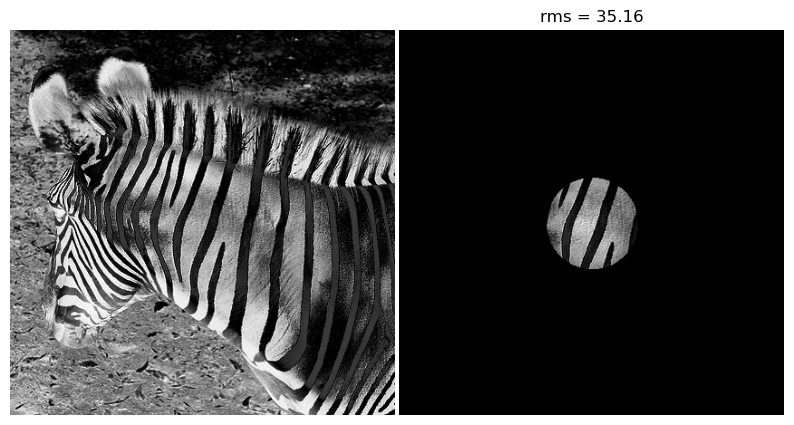

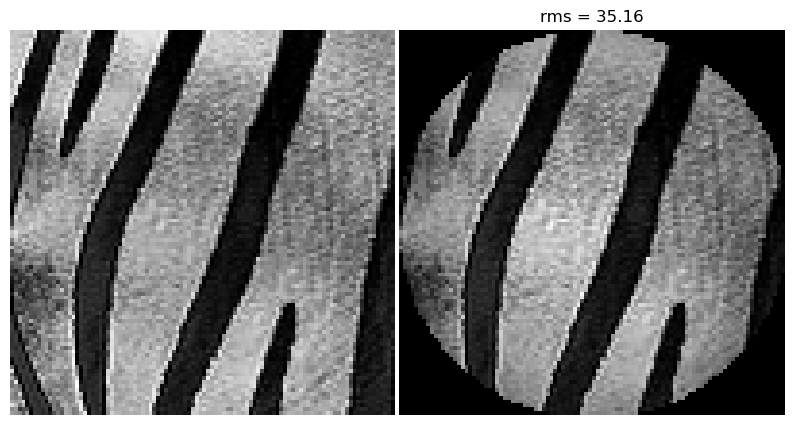

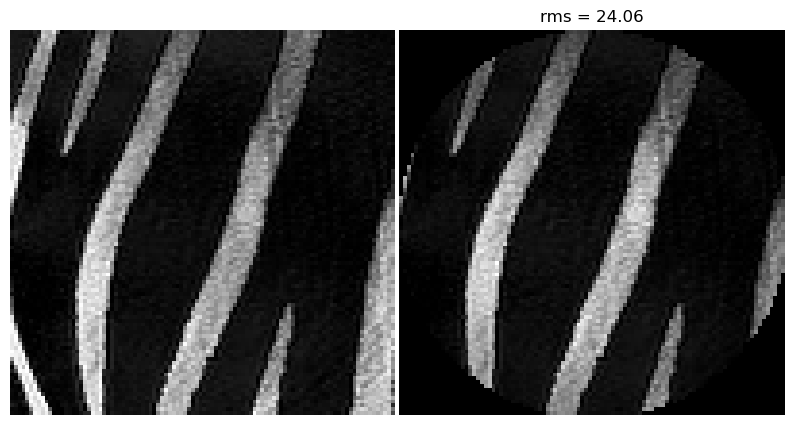

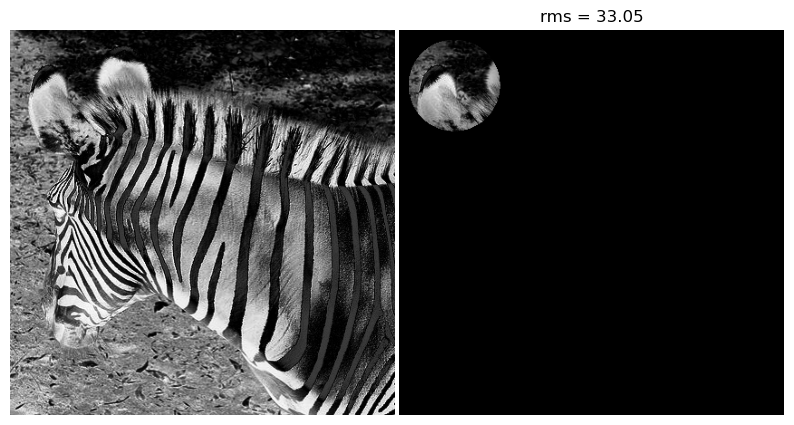

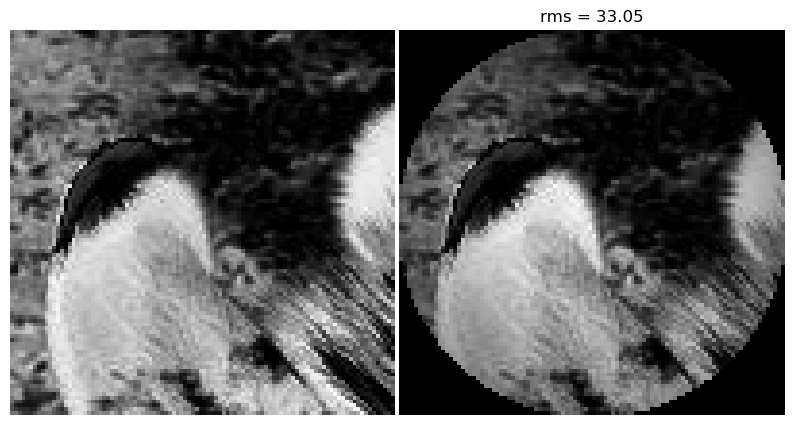

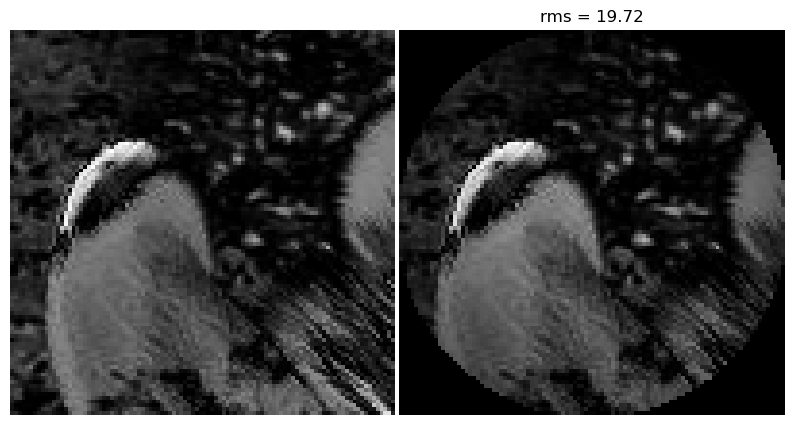

In [67]:
plaat = 121
# Central patch
_ = rms_single((plaat, 0, 5, 'y', 'center', False, False, False), ecc_max = 1, cmap = 'gray') # No crop
_ = rms_single((plaat, 0, 5, 'y', 'center', False, True, False), ecc_max = 1, cmap = 'gray') # Crop prior
_ = rms_single((plaat, 0, 5, 'y', 'center', True, False, False), ecc_max = 1, cmap = 'gray') # Crop posterior

# Peripheral patch
_ = rms_single((plaat, 0, 5, 'y', 'irrelevant_patch', False, False, False), ecc_max = 1, cmap = 'gray') # No crop
_ = rms_single((plaat, 0, 5, 'y', 'irrelevant_patch', False, True, False), ecc_max = 1, cmap = 'gray') # Crop prior
_ = rms_single((plaat, 0, 5, 'y', 'irrelevant_patch', True, False, False), ecc_max = 1, cmap = 'gray') # Crop posterior


In [21]:
img1 = rms_single((121, 0, 5), ecc_max = 1, loc = 'center', plot = 'n', crop = False, cmap = 'afmhot')
print(type(img1))
print(img1.shape)

<class 'numpy.float64'>
()


### Below I tried implementing the edge_maps calculations outside of the lgn_stats thing, but failed so far.

In [79]:
import warnings
from scipy.interpolate import interp1d

def get_edge_maps(im, file_name, threshold_lgn, lgn, IMTYPE, imsize, verbose:bool=False, force_recompute:bool=False, results=None, cache:bool=False, result_manager=None):
    if force_recompute or results is None:
        ######
        # Computing edges
        ######
        par1 = np.zeros(imsize)
        par2 = np.zeros(imsize)
        par3 = np.zeros(imsize)
        mag1 = np.zeros(imsize)
        mag2 = np.zeros(imsize)
        mag3 = np.zeros(imsize)

        # par_sigmas = [48, 24, 12, 6, 3]
        # mag_sigmas = [64, 32, 16, 8, 4]
        parvo_sigmas = lgn.get_attr('parvo_sigmas')
        magno_sigmas = lgn.get_attr('magno_sigmas')

        interpolation_sigmas = lgn.get_attr('interpolation_sigmas')
        eps = lgn.get_attr('eps')

        for iteration_index, sigma_iterations in enumerate(np.array([parvo_sigmas, magno_sigmas])):
            for _, sigma in enumerate(sigma_iterations):
                if verbose:
                    print(f"Sigma: {sigma}")

                if verbose:
                    print('Interpolate')
                sigmas = np.array(interpolation_sigmas)
                v1 = np.squeeze(threshold_lgn[:, 0])
                t1_interp = interp1d(sigmas, v1, kind='linear',
                                    bounds_error=False, fill_value=np.nan)
                t1 = t1_interp(sigma)
                v2 = np.squeeze(threshold_lgn[:, 1])
                t2_interp = interp1d(sigmas, v2, kind='linear',
                                    bounds_error=False, fill_value=np.nan)
                t2 = t2_interp(sigma)
                v3 = np.squeeze(threshold_lgn[:, 2])
                t3_interp = interp1d(sigmas, v3, kind='linear',
                                    bounds_error=False, fill_value=np.nan)
                t3 = t3_interp(sigma)

                if verbose:
                    print("Filter LGN")
                o1, o2, o3 = lgn.filter_lgn(im, sigma)

                if verbose:
                    print("Local COV 1")
                s1 = lgn.local_cov(o1, sigma)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    e1 = ((o1 * np.max(o1)) / (o1 + np.max(o1) * s1))
                minm1 = e1 - t1
                index1 = (minm1 > eps)
                print(f'minm1: {minm1}')
                print(f'index1: {index1}')
                
                if iteration_index == 0:
                    par1[index1] = minm1[index1]
                elif iteration_index == 1:
                    mag1[index1] = minm1[index1]

                if IMTYPE == 2:
                    if verbose:
                        print("Local COV 2")
                    s2 = lgn.local_cov(o2, sigma)
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        e2 = ((o2 * np.max(o2)) / (o2 + np.max(o2) * s2))
                    minm2 = e2 - t2
                    index2 = (minm2 > eps)
                    if iteration_index == 0:
                        par2[index2] = minm2[index2]
                    elif iteration_index == 1:
                        mag2[index2] = minm2[index2]

                    if verbose:
                        print("Local COV 3")
                    s3 = lgn.local_cov(o3, sigma)
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        e3 = ((o3 * np.max(o3)) / (o3 + np.max(o3) * s3))
                    minm3 = e3 - t3
                    index3 = (minm3 > eps)
                    if iteration_index == 0:
                        par3[index3] = minm3[index3]
                    elif iteration_index == 1:
                        mag3[index3] = minm3[index3]

    
        if cache and result_manager is not None:
            # results = np.array((par1, par2, par3, mag1, mag2, mag3))
            # result_manager.save_result(result=results, filename=file_name, overwrite=True)
            results = {"par1": par1, "par2": par2, "par3": par3, "mag1": mag1, "mag2": mag2, "mag3": mag3}
            result_manager.save_result(result=results, filename=file_name, overwrite=True)
            del results
    else:
        # par1, par2, par3, mag1, mag2, mag3 = results
        par1, par2, par3, mag1, mag2, mag3 = results['par1'], results['par2'], results['par3'], results['mag1'], results['mag2'], results['mag3']
    return par1,par2,par3,mag1,mag2,mag3


dimensies: (256, 256, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


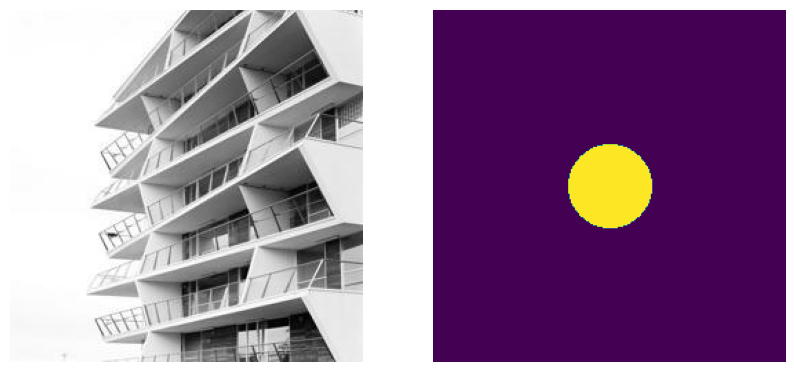

In [29]:
afb = cv2.imread(image_files[0])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(afb)
ax[0].axis('off')



print(f'dimensies: {afb.shape}')

masker = make_circle_mask(afb.shape[0], afb.shape[0]//2, afb.shape[1]//2, afb.shape[0]/8.4, fill='y')
ax[1].imshow(masker)
ax[1].axis('off')




In [74]:
ce, sc, beta, gamma = lgn_statistics(im=image_files[img_ix], file_name='noname.tiff',
                                        config=config, force_recompute=True, cache=False,
                                        home_path='./',
                                        threshold_lgn=threshold_lgn)

Computing LGN statistics for noname.tiff


/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/lgn_statistics.py:523: RuntimeWarning: invalid value encountered in scalar divide
  ce[2, mask_index+1, 0] = box_center
/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/lgn_statistics.py:525: RuntimeWarning: invalid value encountered in scalar divide
  ce[2, mask_index+1, 1] = box_peri


In [64]:
from lgnpy.CEandSC.lgn_statistics import LGN
from scip

Sigma: 48
Interpolate
Filter LGN


AttributeError: 'str' object has no attribute 'ndim'

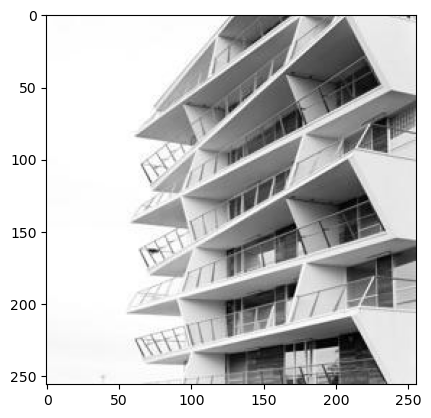

In [84]:
lgn = LGN(config=config, default_config_path=f'./lgnpy/lgnpy/CEandSC/default_config.yml')


plaatje = image_files[0]

plt.imshow(cv2.imread(image_files[0]))


par1, par2, par3, mag1, mag2, mag3 = get_edge_maps(im=plaatje, file_name='noname.tiff', 
                                                   threshold_lgn=threshold_lgn, verbose=True, 
                                                   force_recompute=True, cache=False, 
                                                   result_manager=False, lgn=lgn, results=True, 
                                                   IMTYPE=2, imsize=225)


In [76]:

contr_df


,img_ix,CE_summ,SC_summ
0,0000,0.003960,0.662600
1,0001,0.004642,1.156945
2,0002,0.003758,1.087976
3,0003,0.001242,0.561501
4,0004,0.001271,0.443871


---------
# Compute contrast with spatial-frequency-specific filterbank
## (Micha method)

Below we compute "rms_contrast" (works well, at least for grayscale images), and with a gabor filterbank, which I implemented.

It is not very efficient (sorry!) but it does work with GPU accelaration :)


In [14]:
# deg_per_pixel=.049
print('degree per pixel:', deg_per_pixel)
print('make sure to recompute to get actual value!')

degree per pixel: 0.04943074353418329
make sure to recompute to get actual value!


In [20]:
!{sys.executable} -m pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 28.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 57.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 20.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 19.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

In [21]:
from gabor.contrast import ContrastModel
contrast_model_small=ContrastModel(deg_per_pixel,spat_freqs='human',orientations=6)
cols,rows = np.meshgrid(np.arange(256), np.arange(256))
from PIL import Image
import glob
mask=np.array(Image.open('selected_imgs/mask.png'))
image_files=glob.glob('selected_imgs/*.jpg')

My contrast model works the following way:

1. Convolve raw image with filterbanks to create a series of "heat maps", where the "heat" in each pixel expresses the energy in that specific angle and spatial frequency
2. Do this for a range of scales
3. For every energy map, compute "contrast energy" as the spatial mean of energy across a given region (e.g. the image patch); compute the "spatial coherence" as the mean/SD of that region


(-0.5, 255.5, 255.5, -0.5)

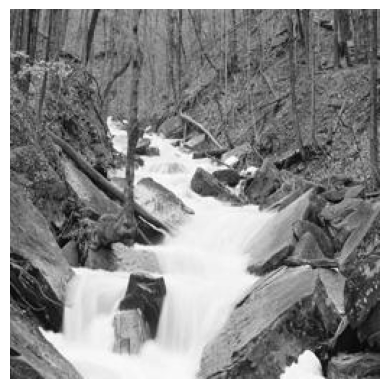

In [24]:
image=np.array(Image.open(image_files[100]))
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

plt.imshow(image)
plt.axis('off')

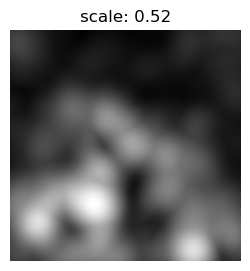

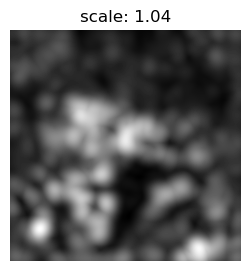

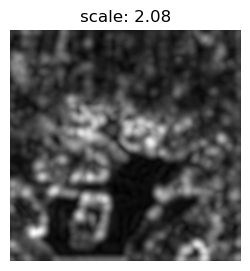

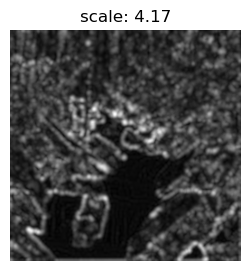

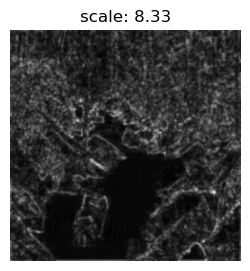

In [31]:
energy_maps,energy_maps_norm=contrast_model_small.compute_CE_SC_maps(image)
for scale_i in range(5):
    CE_scale=contrast_model_small.spat_freqs['CE'][scale_i]
    for fbank_name in ['CE']:
        this_map=energy_maps[fbank_name][scale_i,:,:]
        this_scale=contrast_model_small.spat_freqs[fbank_name][scale_i]
        this_name=f'figs/illu/birda_{fbank_name}-{this_scale}.png'
#         plt.saveig()
        plt.figure(figsize=(3,3))
        plt.title(f'scale: {this_scale}')
        plt.imshow(this_map)
        plt.axis('off')


The code below extracts the local contrast metrics for every image, looping over images (can take a while!)

Note: code can be made much faster if we'd create a new, refactored class, that doesn't use stride=1. Normally, people use a so-called pyramid arrangement,  where each bank features larger filters (sigma) and a greater stride. The change in stride results in a pyramid arrangement of arrays - the top of the pyramid is a small number of very large filters, and the bottom a large number of small filters. Each level of the pyramid then encodes a particular spatial frequency band in an efficient manner by using fewer filters to encode coarser, low-spatial frequency content.

With some help of chatGPT4 this shouldn't be too hard to implement.

Alternative is just to keep this running for a long time, and compute it once



In [26]:
def _pack_in_dict(stim_dict_in:dict,c_keys:list,c_vals:np.ndarray):
    """from list of variables and keys, append each to the dict of lists"""
    for c_k,c_v in zip(c_keys,c_vals):
        stim_dict_in[c_k].append(c_v)
    return(stim_dict_in)
import time
def _get_sc(map_in:np.array,mask_in:np.array):
    return(map_in[mask_in].std()/map_in[mask_in].mean()) # SD/mean
def _get_ce(map_in:np.array,mask_in:np.array):
    return(map_in[mask_in].mean())
def _get_rms_contrast(ar_in,normalise=True):
    if normalise:ar_in=ar_in/ar_in.max()
    return(np.sqrt(np.mean(np.square((ar_in-ar_in.mean()))))) # root mean square (RMS)

def _compute_local_contrasts(cmap_in,mask_in):
    CE=cmap['CE'].data[:,mask].mean(axis=1)
    SC=cmap['SC'].data[:,mask_in].mean(axis=1)/cmap['SC'].data[:,mask_in].std(axis=1)
    return({'CE':CE,'SC':SC})


# prepare list
contr_attrs=[]
for fbank in contrast_model_small.spat_freqs:
    contr_attrs+=[f'{fbank}_{sf}' for sf in contrast_model_small.spat_freqs[fbank]]
features_of_interest=['img_ix','rms_contrast']+contr_attrs
stim_dict={feat:[] for feat in features_of_interest}

tstart=time.time()
img_all = len(image_files)
img_sel = 3
for img_ix in range(img_sel):
    if img_ix%500==0: # prints where we are every 500 images
        print(f'now doing img {img_ix}/{len(image_files)}')
        print('time elapsed so far: ',round(time.time()-tstart,2))
    this_img=np.array(Image.open(image_files[img_ix]))

    # compute contrasts
    cmap,cmap_norm=contrast_model_small.compute_CE_SC_maps(this_img)
    contr_dict=_compute_local_contrasts(cmap,mask)
    rms_contrast=_get_rms_contrast(this_img[mask])

    #
    for fbank in ('CE','SC'): # unpack "CE_xxx" and "SC_xxx" features
        these_contr_attrs=[fea for fea in features_of_interest if f'{fbank}_' in fea]
        if any(contr_attrs): stim_dict=_pack_in_dict(stim_dict,these_contr_attrs,contr_dict[fbank])

    # fill the dict
    stim_dict['img_ix'].append(img_ix)
    stim_dict['rms_contrast'].append(rms_contrast)
contr_df=pd.DataFrame(stim_dict)

now doing img 0/6901
time elapsed so far:  0.0


/tmp/ipykernel_3920456/1255019447.py:17: RuntimeWarning: divide by zero encountered in divide
  SC=cmap['SC'].data[:,mask_in].mean(axis=1)/cmap['SC'].data[:,mask_in].std(axis=1)


(-0.5, 255.5, 255.5, -0.5)

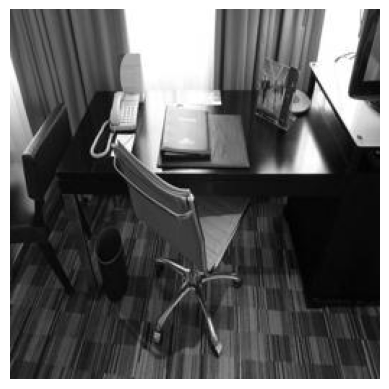

In [30]:
this_img=np.array(Image.open(image_files[img_ix]))
plt.imshow(this_img)
plt.axis('off')

In [27]:
contr_df

,img_ix,rms_contrast,CE_0.52,CE_1.04,CE_2.08,CE_4.17,CE_8.33,SC_0.39,SC_0.78,SC_1.56,SC_3.12,SC_6.25
0,0,0.194514,"[[6.518029, 6.7427955, 6.9702234, 7.200105, 7....","[[6.2213125, 6.4806285, 6.696567, 6.866098, 6....","[[3.6616778, 3.8317387, 3.8784301, 3.8101325, ...","[[1.7067639, 1.7170123, 1.5366517, 1.2894787, ...","[[1.0671384, 0.8122899, 0.56209815, 0.62577665...","[[310665.88, 744245.6, 406044.94, 520679.8, 67...","[[1003618.3, 323591.97, 540143.06, 351201.25, ...","[[333873.7, 502233.66, 580975.56, 484268.3, 43...","[[477245.78, 496667.0, 12890369.0, 983357.4, 4...","[[994645.1, 1238905.8, 554731.9, 308787.94, 53..."
1,1,0.318921,"[[15.692188, 16.030811, 16.347225, 16.641054, ...","[[10.8354435, 11.233709, 11.548848, 11.776143,...","[[7.4209957, 7.801911, 7.9362555, 7.8345942, 7...","[[3.6096358, 3.6129632, 3.1930351, 2.6188586, ...","[[2.195762, 1.7350072, 1.2437531, 1.223316, 1....","[[567394.9, 525297.6, 342826.16, 300851.9, 277...","[[436991.78, 1682771.1, 403661.5, 425799.34, 6...","[[778147.8, 292174.88, 594411.94, 5476778.5, 5...","[[344088.88, 688812.06, 318870.47, 392296.03, ...","[[1023299.25, 309665.84, 1159261.9, 2565479.5,..."
2,2,0.308414,"[[0.9638832, 0.97900313, 0.9936335, 1.0079807,...","[[0.2214587, 0.21915708, 0.21557616, 0.2112587...","[[0.4450816, 0.47929332, 0.5058512, 0.5261837,...","[[0.36000842, 0.38203242, 0.36277062, 0.299041...","[[0.25188142, 0.22105049, 0.12916392, 0.102929...","[[808563.9, 566377.5, 378872.8, 1207936.4, 535...","[[362483.94, 288380.06, 4822357.0, 1288848.9, ...","[[382934.88, 392254.03, 471487.5, 679069.06, 2...","[[671104.3, 1424320.1, 486902.47, 1254272.2, 9...","[[528233.6, 463576.47, 722337.0, 531347.06, 84..."
